In [4]:
import pandas as pd
import numpy as np
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
np.random.seed(1322)
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# HW3:  Классификация имен
В этом домашнем задании мы рассмотрим задачу бинарной классификации. Пусть дано два списка имен:  мужские и женские имена.  Требуется разработать классификатор, который по данному имени будет определять мужское оно или женское.
### Выполнили:  

* Булгаков Дмитрий

* Тефикова Алие

### Группа ИАД-2

## 0. Loading data

In [5]:
male_names = pd.read_csv('data/male.txt', header=-1, names=['name'], encoding = 'latin1')
female_names = pd.read_csv('data/female.txt', header=-1, names=['name'], encoding = 'latin1')

In [6]:
male_names_number = len(male_names)
female_names_number = len(female_names)
print('Количество мужских имен: ', male_names_number)
print('Количество женских имен: ', female_names_number)

Количество мужских имен:  2943
Количество женских имен:  5001


## 1. Filtering data

Предварительная обработка данных:<br>
* удалите неоднозначные имена (те имена, которые являются и мужскими, и женскими одновременно), если такие есть.<br>
* создайте тестовое множество по следующему принципу: 20% от общего количества имен на каждую букву (т.е. 20% от имен на букву А, 20% имен на букву B, и.т.д.)

### 1.1 Looking for same names in both male and female df

In [7]:
same_names = female_names.merge(male_names, on=['name'], how='inner')
print('Количество совпадающих имен: ', len(same_names))
print('Список имен, являющихся одновременно и мужскими, и женскими: (первые 10)')
same_names.head(n = 10)

Количество совпадающих имен:  365
Список имен, являющихся одновременно и мужскими, и женскими: (первые 10)


,name
0,Abbey
1,Abbie
2,Abby
3,Addie
4,Adrian
5,Adrien
6,Ajay
7,Alex
8,Alexis
9,Alfie


### 1.2 And deleting duplicated names

In [8]:
remove_criterion = lambda row: row['name'] not in same_names['name'].values
male_names = male_names[male_names.apply(remove_criterion, axis=1)]
female_names = female_names[female_names.apply(remove_criterion, axis=1)]

In [9]:
print('Количество мужских имен после удаления дубликатов: ', len(male_names))
print('Количество женских имен после удаления дубликатов: ', len(female_names))
print('Все ок? ', (male_names_number - len(same_names) == len(male_names)) & 
      (female_names_number - len(same_names) == len(female_names)))

Количество мужских имен после удаления дубликатов:  2578
Количество женских имен после удаления дубликатов:  4636
Все ок?  True


### 1.3 Creating test sample (20% of dataset)

In [11]:
def createTrainTestSample(dataframe, letters_list, field, field2, test_percentage=0.2, rnd_state=0):
    train_X, train_y, test_X, test_y = ([] for i in range(4))
    for letter_value in letters_list:
        letter_df = dataframe[dataframe[field].str.startswith(letter_value)]
        X_train, X_test, y_train, y_test = train_test_split(letter_df[field].tolist(), letter_df[field2].tolist(), 
                                                            test_size=test_percentage, random_state=rnd_state)
        train_X.extend(X_train)
        test_X.extend(X_test)
        train_y.extend(y_train)
        test_y.extend(y_test)
    return train_X, test_X, train_y, test_y

In [12]:
def getListOfFirstLetters(dataframe, field):
    letters = dataframe[field].astype(str).str[0]
    letters = np.unique(letters.tolist())
    return letters

In [13]:
all_names = pd.concat([male_names, female_names], axis=0, ignore_index=True)
all_names['gender'] = np.concatenate((np.ones(len(male_names)), np.zeros(len(female_names))), axis=0).astype(int)
print('Общее количество имен: ', len(all_names))
print('Все ок? ', len(all_names) == len(male_names) + len(female_names))

Общее количество имен:  7214
Все ок?  True


(array([0, 1]), <a list of 2 Text xticklabel objects>)

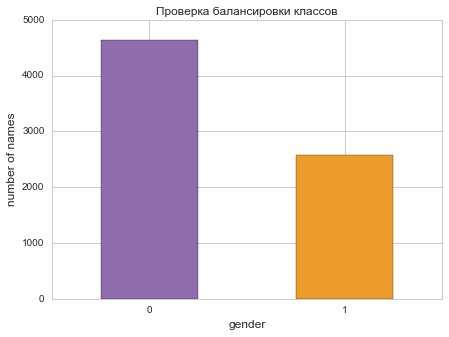

In [20]:
plt.figure(figsize = (7, 5))
plt.title('Проверка балансировки классов', fontsize = 12)
plt.xlabel('gender', fontsize = 12)
plt.ylabel('number of names',  fontsize = 12)
all_names['gender'].value_counts().plot(kind='bar', color = ['#8F6CAC', '#ED9C2C'])
plt.xticks(rotation = 0)

Как видим, мужских имен в выборке почти в два раза меньше, чем женских, что говорит о том, что наши классы не сбалансированы. 

In [14]:
# getting list of fisrt letters of names
lettes_list = getListOfFirstLetters(all_names, 'name')
print('Список первых букв имен, присутствующих в датасете:')
lettes_list

Список первых букв имен, присутствующих в датасете:


array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], 
      dtype='<U1')

In [15]:
%%time
X_train, X_test, y_train, y_test = createTrainTestSample(all_names, lettes_list, 'name', 'gender') 

CPU times: user 152 ms, sys: 3.37 ms, total: 156 ms
Wall time: 156 ms


## 2. Fitting Naive Bayes classifier

Используйте метод наивного Байеса для классификации имен: в качестве признаков используйте символьные n-граммы. <br>Сравните результаты, получаемые при разных n= 2, 3, 4 по F-мере и аккуратности. В каких случаях метод ошибается? <br>Для генерации n-грамм используйте <br><b>from nltk.util import ngrams.<b>

In [12]:
def remove_duplicates(list_to_filter):
    return list(set(list_to_filter))

In [13]:
def tuple_to_string(tuple_to_convert):
    return ''.join(tuple_to_convert)

In [14]:
def generateNgrams(dataframe, field, n):
    all_ngrams_list = []
    for name_value in dataframe[field].str.lower():
        for ngram in ngrams(name_value, n):
            all_ngrams_list.append(ngram)
    return remove_duplicates(all_ngrams_list)

In [15]:
def genFitMatrix(names_list, all_features):
    matrix = np.zeros((len(names_list), len(all_features)))
    for i, name_value in enumerate(names_list):
        for j, feature_value in enumerate(all_features):
            if tuple_to_string(feature_value) in name_value:
                matrix[i][j] = 1
    return matrix

### 2. 1 Model with bigram features (ngrams = 2)

In [16]:
list_ngrams = generateNgrams(all_names, 'name', 2)
X_train_matrix = genFitMatrix(X_train, list_ngrams)
X_test_matrix = genFitMatrix(X_test, list_ngrams)

In [17]:
clf = GaussianNB().fit(X_train_matrix, y_train)
y_pred = clf.predict(X_test_matrix)
print("accuracy =", accuracy_score(y_test, y_pred))
print("F-score =", f1_score(y_test, y_pred))

accuracy = 0.699382292382
F-score = 0.376068376068


### 2. 2 Model with trigram features (ngrams = 3)

In [18]:
list_ngrams = generateNgrams(all_names, 'name', 3)
X_train_matrix = genFitMatrix(X_train, list_ngrams)
X_test_matrix = genFitMatrix(X_test, list_ngrams)

In [19]:
clf = GaussianNB().fit(X_train_matrix, y_train)
y_pred = clf.predict(X_test_matrix)
print("accuracy =", accuracy_score(y_test, y_pred))
print("F-score =", f1_score(y_test, y_pred))

accuracy = 0.743994509266
F-score = 0.524840764331


### 2. 3 Model with four-gram features (ngrams = 4)

In [20]:
list_ngrams = generateNgrams(all_names, 'name', 4)
X_train_matrix = genFitMatrix(X_train, list_ngrams)
X_test_matrix = genFitMatrix(X_test, list_ngrams)

In [21]:
clf = GaussianNB().fit(X_train_matrix, y_train)
y_pred = clf.predict(X_test_matrix)
print("accuracy =", accuracy_score(y_test, y_pred))
print("F-score =", f1_score(y_test, y_pred))

accuracy = 0.732326698696
F-score = 0.705882352941


Таким образом, использование разных n-грамм в действительности заметно влияет на качество модели, особенно это видно по значению метрики fmeasure. Что касается сравнительных результатов, то можно сказать следующее: наибольшее значение accuracy (~0.74) достигается при использовании в качестве признаков - триграм, но при этом ф-мера достаточно мала (~0.53), в таком случае оптимальным выбором n в генерации символьных n-gramm является 4. Используя four-grams, обе метрики показывают довольно высокое значение ~0.73 и ~0.71 соответственно. 

## 3. Fitting Neural Network

### 3.1 Preparing the data before training 

In [22]:
#checking number of duplicated names
k = 0 
for i in all_names.index:
     if all_names.name.value_counts()[i] > 1: 
        k = k + 1
k

0

In [23]:
#max name length
max_len = 0
for i in all_names.index:
    if len(all_names.name.values[i]) > max_len:
        max_len = len(all_names.name.values[i])
max_len

15

In [24]:
#all names to lower case
male = male_names.name.str.lower()
female = female_names.name.str.lower()

In [25]:
#extracting the chars 
chars = set("".join(male) + "".join(female))
char_indices = dict((c, i) for i, c in enumerate(chars))
print('Number of chars:', len(chars))

Number of chars: 29


In [26]:
X = np.zeros((len(all_names), max_len, len(chars)), dtype = np.bool)
y = np.zeros((len(all_names), 2), dtype = np.bool)

for i, name in enumerate(male):
    for t, char in enumerate(name):
        X[i, t, char_indices[char]] = 1
    y[i, 0 ] = 1

for i, name in enumerate(female):
    for t, char in enumerate(name):
        X[i + len(male), t, char_indices[char]] = 1
    y[i + len(male), 1] = 1

### 3. 2 Training the model with different configurations

В качестве "конфигураций" будут рассматриваться разные значения dropout, который используется для предотвращения переобучения, а также разные значения количества узлов на слоях нейронной сети. 

In [70]:
num_epochs = 5 
batch_size = 16
weightsFileName = "gender_weights.h5"

***Configuration № 1***

======================================================================================================================

* Dropout = 0.2
* Nodes = 512
* Added extra dropout after second layer

In [51]:
#bulding model
model = Sequential()
model.add(LSTM(512, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(512, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Dropout(0.2))
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X, y, batch_size = batch_size, nb_epoch = num_epochs,
          validation_split = 0.1, verbose = 1)

model.save_weights('my_model_weights.h5')
result = model.evaluate(X, y, batch_size = batch_size)
print("Results: ", result)

Train on 6492 samples, validate on 722 samples
Epoch 1/5
6492/6492 [==============================] - 191s - loss: 0.6620 - fmeasure: 0.6209 - acc: 0.6283 - val_loss: 5.2378 - val_fmeasure: 0.1191 - val_acc: 0.1191

***Configuration № 2***

======================================================================================================================

* Dropout = 0.5
* Nodes = 512
* Added extra dropout after second layer

In [53]:
#bulding model
model = Sequential()
model.add(LSTM(512, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.5)) #adding dropout to reduce overfitting
model.add(LSTM(512, return_sequences = False)) #second layer
model.add(Dropout(0.5))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Dropout(0.5))
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X, y, batch_size = batch_size, nb_epoch = num_epochs,
          validation_split = 0.1, verbose = 1)

model.save_weights('my_model_weights.h5')
result = model.evaluate(X, y, batch_size = batch_size)
print("Results: ", result)

Train on 6492 samples, validate on 722 samples
Epoch 1/5
6492/6492 [==============================] - 179s - loss: 0.7646 - fmeasure: 0.4887 - acc: 0.5526 - val_loss: 5.4638 - val_fmeasure: 0.1163 - val_acc: 0.1163

***Configuration № 3***

======================================================================================================================

* Dropout = 0.2
* Nodes = 256
* Added extra dropout after second layer

In [27]:
#bulding model
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(256, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Dropout(0.2))
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X, y, batch_size = batch_size, nb_epoch = num_epochs,
          validation_split = 0.1, verbose = 1)

model.save_weights('my_model_weights.h5')
result = model.evaluate(X, y, batch_size = batch_size)
print("Results: ", result)

Train on 6492 samples, validate on 722 samples
Epoch 1/5
6492/6492 [==============================] - 83s - loss: 0.5824 - fmeasure: 0.7068 - acc: 0.7130 - val_loss: 1.1420 - val_fmeasure: 0.4058 - val_acc: 0.4058
Epoch 2/5
6492/6492 [==============================] - 78s - loss: 0.5505 - fmeasure: 0.7285 - acc: 0.7342 - val_loss: 4.2362 - val_fmeasure: 0.0734 - val_acc: 0.0734
Epoch 3/5
6492/6492 [==============================] - 79s - loss: 0.5149 - fmeasure: 0.7550 - acc: 0.7606 - val_loss: 2.9500 - val_fmeasure: 0.1524 - val_acc: 0.1524
Epoch 4/5
6492/6492 [==============================] - 79s - loss: 0.4959 - fmeasure: 0.7551 - acc: 0.7607 - val_loss: 3.6719 - val_fmeasure: 0.1994 - val_acc: 0.1994
Epoch 5/5
7214/7214 [==============================] - 19s    
Results:  [0.61273271035369958, 0.76060434239770625, 0.76060438037563105]


После попытки обучить модель с разным значением dropout и nodes, мы поняли, что необходимо разделить выборку. Но тем не менее, даже из вышеизложенных примеров можно сделать вывод о том, что оптимальнее брать количество узлов равным 256, чем 512, а dropout равным 0.2.

### 3. 3 With validation data

Разделим нашу выборку с учетом валидации. 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8778)

И также проверим модель при разных значениях узлов и dropout.

*Configuration № 1* 

======================================================================================================================

* Dropout = 0.2
* Nodes = 256

In [32]:
#bulding model
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(256, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          validation_split = 0.1, verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config1 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config1)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 77s - loss: 0.5424 - fmeasure: 0.7338 - acc: 0.7338 - val_loss: 0.5565 - val_fmeasure: 0.7436 - val_acc: 0.7436
Epoch 2/5
5771/5771 [==============================] - 71s - loss: 0.4801 - fmeasure: 0.7815 - acc: 0.7815 - val_loss: 0.4339 - val_fmeasure: 0.8080 - val_acc: 0.8080
Epoch 3/5
5771/5771 [==============================] - 70s - loss: 0.4451 - fmeasure: 0.7967 - acc: 0.7967 - val_loss: 0.5442 - val_fmeasure: 0.7429 - val_acc: 0.7429
Epoch 4/5
5771/5771 [==============================] - 70s - loss: 0.4192 - fmeasure: 0.8085 - acc: 0.8085 - val_loss: 0.4072 - val_fmeasure: 0.8115 - val_acc: 0.8115
Epoch 5/5
1443/1443 [==============================] - 3s     
Results:  [0.40610135526848767, 0.821898765639968, 0.82189882194012798]


*Configuration № 2* 

======================================================================================================================

* Dropout = 0.2
* Dropout = 0.8
* Nodes = 256

In [34]:
#bulding model
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(256, return_sequences = False)) #second layer
model.add(Dropout(0.8))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          validation_split = 0.1, verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config2 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config2)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 77s - loss: 0.6950 - fmeasure: 0.6202 - acc: 0.6202 - val_loss: 0.6091 - val_fmeasure: 0.6708 - val_acc: 0.6708
Epoch 2/5
5771/5771 [==============================] - 77s - loss: 0.6173 - fmeasure: 0.6751 - acc: 0.6751 - val_loss: 0.5602 - val_fmeasure: 0.7138 - val_acc: 0.7138
Epoch 3/5
5771/5771 [==============================] - 75s - loss: 0.5747 - fmeasure: 0.7103 - acc: 0.7103 - val_loss: 0.5201 - val_fmeasure: 0.7360 - val_acc: 0.7360
Epoch 4/5
5771/5771 [==============================] - 73s - loss: 0.5474 - fmeasure: 0.7377 - acc: 0.7377 - val_loss: 0.5350 - val_fmeasure: 0.7443 - val_acc: 0.7443
Epoch 5/5
1440/1443 [============================>.] - ETA: 0sResults:  [0.46104872439441297, 0.79625773867714844, 0.79625779629910232]


Также пробовали делать dropout после первого слоя 0.8, а после второго 0.2, метрики почти не изменились. 

*Configuration № 3* 

======================================================================================================================

* Dropout = 0.2
* Nodes = 512

In [53]:
#bulding model
model = Sequential()
model.add(LSTM(512, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(512, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config3 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config3)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 173s - loss: 0.6951 - fmeasure: 0.6068 - acc: 0.6068 - val_loss: 0.6560 - val_fmeasure: 0.6369 - val_acc: 0.6369
Epoch 2/5
5771/5771 [==============================] - 158s - loss: 0.6626 - fmeasure: 0.6259 - acc: 0.6259 - val_loss: 0.6422 - val_fmeasure: 0.6348 - val_acc: 0.6348
Epoch 3/5
5771/5771 [==============================] - 159s - loss: 0.6410 - fmeasure: 0.6460 - acc: 0.6460 - val_loss: 0.6340 - val_fmeasure: 0.6597 - val_acc: 0.6597
Epoch 4/5
5771/5771 [==============================] - 280s - loss: 0.6432 - fmeasure: 0.6531 - acc: 0.6531 - val_loss: 0.6270 - val_fmeasure: 0.6542 - val_acc: 0.6542
Epoch 5/5
1443/1443 [==============================] - 10s    
Results:  [0.63707730147215702, 0.65835059886993175, 0.65835065835065831]


*Configuration № 4* 

======================================================================================================================

* Dropout = 0.5
* Nodes = 256

In [38]:
#bulding model
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.5)) #adding dropout to reduce overfitting
model.add(LSTM(256, return_sequences = False)) #second layer
model.add(Dropout(0.5))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config4 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config4)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 74s - loss: 0.6886 - fmeasure: 0.6139 - acc: 0.6139 - val_loss: 0.6367 - val_fmeasure: 0.6570 - val_acc: 0.6570
Epoch 2/5
5771/5771 [==============================] - 72s - loss: 0.6417 - fmeasure: 0.6436 - acc: 0.6436 - val_loss: 0.6344 - val_fmeasure: 0.6396 - val_acc: 0.6396
Epoch 3/5
5771/5771 [==============================] - 71s - loss: 0.6371 - fmeasure: 0.6548 - acc: 0.6548 - val_loss: 0.6257 - val_fmeasure: 0.6590 - val_acc: 0.6590
Epoch 4/5
5771/5771 [==============================] - 71s - loss: 0.6327 - fmeasure: 0.6593 - acc: 0.6593 - val_loss: 0.6336 - val_fmeasure: 0.6590 - val_acc: 0.6590
Epoch 5/5
1440/1443 [============================>.] - ETA: 0sResults:  [0.66884315860659727, 0.63548157591829679, 0.63548163552294157]


*Configuration № 5* 

======================================================================================================================

* Dropout = 0.2
* Nodes = 1024

In [39]:
#bulding model
model = Sequential()
model.add(LSTM(1024, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(1024, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config5 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config5)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 545s - loss: 0.7376 - fmeasure: 0.5931 - acc: 0.5931 - val_loss: 0.7453 - val_fmeasure: 0.6369 - val_acc: 0.6369
Epoch 2/5
5771/5771 [==============================] - 534s - loss: 0.6870 - fmeasure: 0.6254 - acc: 0.6254 - val_loss: 0.6318 - val_fmeasure: 0.6577 - val_acc: 0.6577
Epoch 3/5
5771/5771 [==============================] - 532s - loss: 0.6630 - fmeasure: 0.6274 - acc: 0.6274 - val_loss: 0.6295 - val_fmeasure: 0.6521 - val_acc: 0.6521
Epoch 4/5
5771/5771 [==============================] - 531s - loss: 0.6609 - fmeasure: 0.6342 - acc: 0.6342 - val_loss: 0.6338 - val_fmeasure: 0.6577 - val_acc: 0.6577
Epoch 5/5
1443/1443 [==============================] - 33s    
Results:  [0.64587472138599811, 0.66112260164193448, 0.66112266112266116]


*Configuration № 6* 

======================================================================================================================

* Dropout = 0.2
* Nodes = 256
* Nodes = 512

In [40]:
#bulding model
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(512, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config6 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config6)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 110s - loss: 0.6729 - fmeasure: 0.6320 - acc: 0.6320 - val_loss: 0.6723 - val_fmeasure: 0.6085 - val_acc: 0.6085
Epoch 2/5
5771/5771 [==============================] - 107s - loss: 0.6435 - fmeasure: 0.6477 - acc: 0.6477 - val_loss: 0.6369 - val_fmeasure: 0.6611 - val_acc: 0.6611
Epoch 3/5
5771/5771 [==============================] - 106s - loss: 0.6360 - fmeasure: 0.6489 - acc: 0.6489 - val_loss: 0.6302 - val_fmeasure: 0.6459 - val_acc: 0.6459
Epoch 4/5
5771/5771 [==============================] - 106s - loss: 0.6311 - fmeasure: 0.6455 - acc: 0.6455 - val_loss: 0.6387 - val_fmeasure: 0.6528 - val_acc: 0.6528
Epoch 5/5
1440/1443 [============================>.] - ETA: 0sResults:  [0.65392840544713182, 0.66597360649293935, 0.66597366597366603]


Наибольшее значение метрик fmeasure и accuracy достигается при меньшем (в нашем случае 256) количестве узлов и меньшем значении dropout, что явно видно на предыдущих примерах, где увеличение количества узлов существенно увеличивало также и время обучение, однако при этом значительно уменьшало f-меру и аккуратность. 

Следовательно, далее можно продолжить уменьшать количество узлов и следить за тем, как меняется значение метрик. 
Значение  dropout останется равным 0.2, так как в рассмотренных нами примерах, такое значение является оптимальным.

*Configuration № 7* 

======================================================================================================================

* Dropout = 0.2
* Nodes = 128
* Nodes = 256

In [29]:
#bulding model
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(256, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config7 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config7)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 64s - loss: 0.5184 - fmeasure: 0.7484 - acc: 0.7484 - val_loss: 0.4970 - val_fmeasure: 0.7678 - val_acc: 0.7678
Epoch 2/5
5771/5771 [==============================] - 60s - loss: 0.4721 - fmeasure: 0.7841 - acc: 0.7841 - val_loss: 0.4193 - val_fmeasure: 0.8212 - val_acc: 0.8212
Epoch 3/5
5771/5771 [==============================] - 59s - loss: 0.4425 - fmeasure: 0.7992 - acc: 0.7992 - val_loss: 0.4273 - val_fmeasure: 0.8032 - val_acc: 0.8032
Epoch 4/5
5771/5771 [==============================] - 59s - loss: 0.4171 - fmeasure: 0.8101 - acc: 0.8101 - val_loss: 0.4039 - val_fmeasure: 0.8184 - val_acc: 0.8184
Epoch 5/5
1443/1443 [==============================] - 3s     
Results:  [0.37534651757112741, 0.83229377603497834, 0.83229383233513832]


*Configuration № 8* 

======================================================================================================================

* Dropout = 0.2
* Nodes = 128

In [28]:
#bulding model
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(128, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config8 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config8)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 47s - loss: 0.5279 - fmeasure: 0.7420 - acc: 0.7420 - val_loss: 0.4670 - val_fmeasure: 0.7755 - val_acc: 0.7755
Epoch 2/5
5771/5771 [==============================] - 47s - loss: 0.4668 - fmeasure: 0.7853 - acc: 0.7853 - val_loss: 0.4627 - val_fmeasure: 0.7741 - val_acc: 0.7741
Epoch 3/5
5771/5771 [==============================] - 46s - loss: 0.4387 - fmeasure: 0.7969 - acc: 0.7969 - val_loss: 0.4231 - val_fmeasure: 0.7970 - val_acc: 0.7970
Epoch 4/5
5771/5771 [==============================] - 46s - loss: 0.4177 - fmeasure: 0.8163 - acc: 0.8163 - val_loss: 0.4267 - val_fmeasure: 0.7990 - val_acc: 0.7990
Epoch 5/5
1440/1443 [============================>.] - ETA: 0sResults:  [0.39543878030463053, 0.82259176567207171, 0.82259182263312869]


*Configuration № 9* 

======================================================================================================================

* Dropout = 0.2
* Nodes = 64

In [29]:
#bulding model
model = Sequential()
model.add(LSTM(64, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(64, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config9 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config9)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 47s - loss: 0.5281 - fmeasure: 0.7441 - acc: 0.7441 - val_loss: 0.4746 - val_fmeasure: 0.7678 - val_acc: 0.7678
Epoch 2/5
5771/5771 [==============================] - 45s - loss: 0.4654 - fmeasure: 0.7896 - acc: 0.7896 - val_loss: 0.4643 - val_fmeasure: 0.7886 - val_acc: 0.7886
Epoch 3/5
5771/5771 [==============================] - 45s - loss: 0.4434 - fmeasure: 0.7969 - acc: 0.7969 - val_loss: 0.4371 - val_fmeasure: 0.8067 - val_acc: 0.8067
Epoch 4/5
5771/5771 [==============================] - 43s - loss: 0.4215 - fmeasure: 0.8042 - acc: 0.8042 - val_loss: 0.4037 - val_fmeasure: 0.8184 - val_acc: 0.8184
Epoch 5/5
1440/1443 [============================>.] - ETA: 0sResults:  [0.40505872384921926, 0.80873175123377306, 0.80873180873180872]


*Configuration № 10* 

======================================================================================================================

* Dropout = 0.2
* Nodes = 32

In [31]:
#bulding model
model = Sequential()
model.add(LSTM(32, return_sequences = True, input_shape = (max_len, len(chars)))) #first layer
model.add(Dropout(0.2)) #adding dropout to reduce overfitting
model.add(LSTM(32, return_sequences = False)) #second layer
model.add(Dropout(0.2))

#The output layer will be a softmax layer with two units (one for male, one for female). 
#In other words, target output is a 2-dimensional one hot vector.
model.add(Dense(2)) #linear unit
model.add(Activation('softmax')) 

model.compile(loss = 'binary_crossentropy',  
              metrics = ['fmeasure', 'accuracy'], #reporting the f-measure and accuracy
              optimizer = 'rmsprop')

json_string = model.to_json()
with open("model.json", "w") as text_file:
    text_file.write(json_string)

model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = num_epochs,
          verbose = 1, validation_data = (X_test, y_test))

model.save_weights('my_model_weights.h5')
result_config10 = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Results: ", result_config10)

Train on 5771 samples, validate on 1443 samples
Epoch 1/5
5771/5771 [==============================] - 45s - loss: 0.5507 - fmeasure: 0.7196 - acc: 0.7196 - val_loss: 0.4711 - val_fmeasure: 0.7900 - val_acc: 0.7900
Epoch 2/5
5771/5771 [==============================] - 43s - loss: 0.4768 - fmeasure: 0.7708 - acc: 0.7708 - val_loss: 0.4379 - val_fmeasure: 0.8004 - val_acc: 0.8004
Epoch 3/5
5771/5771 [==============================] - 43s - loss: 0.4466 - fmeasure: 0.7957 - acc: 0.7957 - val_loss: 0.4332 - val_fmeasure: 0.7990 - val_acc: 0.7990
Epoch 4/5
5771/5771 [==============================] - 43s - loss: 0.4368 - fmeasure: 0.8011 - acc: 0.8011 - val_loss: 0.4579 - val_fmeasure: 0.7990 - val_acc: 0.7990
Epoch 5/5
1443/1443 [==============================] - 2s     
Results:  [0.40354535165381611, 0.82259176765476261, 0.82259182263312869]


### 3. 4 Visualization 

In [54]:
nodes_range = [32, 64, 128, 256, 512, 1024] #диапозон узлов 
#значения аккуратности при разных конфигурациях 
accuracy_scores = [result_config10[2], result_config9[2], result_config8[2],
                   result_config1[2],  result_config3[2], 0.66112266112266116]
#значения ф-меры при разных конфигурациях 
fmeasure_scores = [result_config10[1], result_config9[1], result_config8[1],
                   result_config1[1],  result_config3[1], 0.66112260164193448]

([<matplotlib.axis.XTick at 0x1356f67b8>,
 <a list of 6 Text xticklabel objects>)

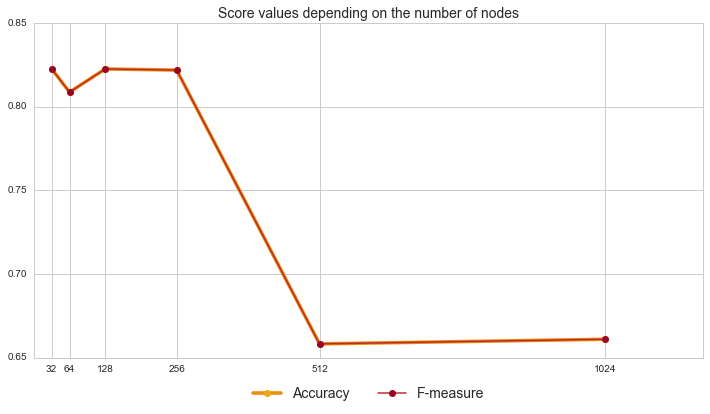

In [69]:
#построение графиков
plt.figure(figsize = (12, 6))
plt.title("Score values depending on the number of nodes", fontsize = 14)
#график зависимости аккуратности от количества узлов на слоях нейронной сети
plt.plot(nodes_range, accuracy_scores, linewidth = 3.5, color = "#EF8A0B", 
           marker = 'o', markerfacecolor = "#F0A60F", label = "Accuracy") 
#график зависимости ф-меры от количества узлов на слоях нейронной сети
plt.plot(nodes_range, fmeasure_scores, linewidth = 1.5, color = '#BA2C2C', 
           marker = 'o', markerfacecolor = "#980623", label = "F-measure")
plt.xscale('linear') #для оси Х устанавливаем линейную шкалу 
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.05), ncol = 2, fontsize = 14)
plt.xticks(nodes_range)

Как видно из графиков, оптимальным количеством узлов являются значения 32, 128 и 256, так как именно при них достигается лучшее качество на тестовой выборке. С увеличением числа узлов метрики показывают достаточно низкое значение, что говорит о плохом качестве предсказания и в целом об обученной модели. 

Что касается оптимального значения dropout, то оно было взято равным 0.2, так как в ходе подбора были взяты значения 0.5, 0.8, а также пробовались разные перестановки между слоями, но все это не давало улучшений тому качеству, которое было достигнуто при dropout = 0.2.

Также из графика следует заметить, что значения метрик - accuracy и fmeasure, не значительно отличаются друг от друга, разница заключается буквально в десяти тысячных, поэтому ширину линии на графиках для лучшей видимости пришлось сделать разной, так как они практически накладываются друг на друга. 

## 4. Comparing models

In [41]:
nb_acc = 0.732326698696
nb_fm = 0.705882352941
lstm_acc = 0.83229383233513832
lstm_fm = 0.83229377603497834
print('===========================')
print(str('Naive bayes classifier:') + '\n' + 
      str('Accuracy:') + str(nb_acc) + '\n' + 
      str('F-measure:') + str(nb_fm))
print('===========================')
print(str('LSTM neural network:') + '\n' + 
      str('Accuracy:') + str(lstm_acc) + '\n' + 
      str('F-measure:') + str(lstm_fm))
print('===========================')

Naive bayes classifier:
Accuracy:0.732326698696
F-measure:0.705882352941
LSTM neural network:
Accuracy:0.8322938323351383
F-measure:0.8322937760349783


Проделав данную работу, мы пришли к выводу, что для решения задачи классификации пола по имени больше подходит нейронная сеть, чем наивный байесовский классификатор, использующий n-граммы в качестве признаков. Такие хорошие результаты нейронной сети достаточно предсказуемы, так как во-первых LSTM neural network относится к рекуррентным нейронным сетям, содержащих в себе обратные связи, позволяющие сохранять информацию, что дает значительное преимущество в использовании их в задачах анализа текстов, а именно в тех случаях, когда текстовый фрагмент представлен нефиксированным количеством предложений, слов, где каждый символ, отдельные слова, знаки препинания и тд, может являться атомарным элементом входной последовательности, а во-вторых даже среди рекуррентных нейронных сетей почти все выдающиеся результаты, основаны именно на этом виде сетей (Long-short term memory). 